In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Necessary Imports



In [2]:
import pandas as pd
import re
import numpy as np

#import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from itertools import combinations
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from lightgbm import LGBMRegressor

from sklearn.model_selection import TimeSeriesSplit

df_pkl = pd.read_pickle("/content/drive/MyDrive/Master_Thesis/Datasets/visuelle2/Extra_Datasets/dataFinal.pkl")
sales = pd.read_csv("/content/drive/MyDrive/Master_Thesis/Datasets/visuelle2/sales.csv")

In [3]:
df = df_pkl.sort_index()
display(df.head())

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,...,10,11,category_encoded,color_encoded,fabric_encoded,image_features,cat_gtrend,col_gtrend,fab_gtrend,date_encoded
0,0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,...,0.0,0.0,11,4,0,2.499182,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[20.0, 18.0, 18.0, 16.0, 18.0, 19.0, 17.0, 18....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0
1,1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,...,1.0,0.0,11,7,0,2.578126,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[56.0, 58.0, 59.0, 54.0, 58.0, 55.0, 58.0, 59....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0
2,2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,...,0.0,1.0,11,4,0,2.499182,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[20.0, 18.0, 18.0, 16.0, 18.0, 19.0, 17.0, 18....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0
3,3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,...,0.0,0.0,1,9,49,1.695715,"[46.0, 52.0, 48.0, 47.0, 47.0, 48.0, 35.0, 56....","[72.0, 73.0, 71.0, 74.0, 74.0, 74.0, 75.0, 77....","[0.0, 17.0, 18.0, 0.0, 0.0, 0.0, 0.0, 17.0, 0....",0
4,4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,...,0.0,0.0,11,4,0,2.499182,"[85.0, 84.0, 76.0, 65.0, 61.0, 59.0, 54.0, 53....","[20.0, 18.0, 18.0, 16.0, 18.0, 19.0, 17.0, 18....","[68.0, 69.0, 71.0, 78.0, 72.0, 69.0, 66.0, 69....",0


# Features Handling

In [4]:
# taking mean of the gtrends to reduce 53 values to a single value.
# taking all the gtrends values introduces complexity without any
# substancial improvement in the forecasting results.

cols = ['cat_gtrend', 'col_gtrend', 'fab_gtrend']

for col in cols:
    df[col] = df[col].apply(np.mean)

#replace NaN with zeros
df.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


# Split Data

In this code, we are preparing training and testing datasets by splitting the original DataFrame into features (X) and target variables (y), and then converting them into NumPy arrays.

In the scaling part, we are only scaling the timeseries, and retaining the original values of other features and later converting the pandas dataframe into numpy arrays.

In the end, we have four NumPy arrays (`x_train`, `y_train`, `x_test`, and `y_test`) that will be used for training and testing models.

In [5]:
#split data
x_train = df[['category_encoded', 'fabric_encoded', 'color_encoded', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','image_features', 'cat_gtrend', 'col_gtrend', 'fab_gtrend','date_encoded']]

y_train = df[['10']]

x_test = df[['category_encoded', 'fabric_encoded', 'color_encoded', '1', '2', '3', '4', '5', '6', '7', '8', '9','10','image_features', 'cat_gtrend', 'col_gtrend', 'fab_gtrend','date_encoded']]

y_test = df[['11']]


x_test_original = x_test.to_numpy()  # saving it for plotting

# Select TimeSeries columns
scale_columns_train = [ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
scale_columns_test = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

# Convert specific DataFrame columns to a NumPy array
x_train_np = x_train.loc[:,scale_columns_train].to_numpy()
x_test_np = x_test.loc[:,scale_columns_test].to_numpy()


# Standardize the NumPy array
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_np)
x_test_scaled = scaler.transform(x_test_np)

# Replace original DataFrame columns with standardized values
x_train.loc[:,scale_columns_train] = x_train_scaled
x_test.loc[:,scale_columns_test] = x_test_scaled

# Convert entire DataFrame to a NumPy array
x_train = x_train.values
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

# Light-GBM Configuration

 The following code is for creating and configuring a LightGBM model using the LightGBM library.

1. **Create LightGBM Dataset:**
   - This creates LightGBM Datasets (`train_data` and `test_data`) from the training (`x_train`, `y_train`) and testing (`x_test`, `y_test`) data.
   - `x_train` and `x_test` are the feature matrices.
   - `y_train` and `y_test` are the corresponding target values.

2. **Define Model Parameters:**
   - `params` is a dictionary containing various parameters that configure the LightGBM model. Here are some key parameters:
     - `'objective': 'regression'`: Specifies that this is a regression task.
     - `'metric': 'mse'`: Uses Mean Squared Error as the evaluation metric.
     - `'boosting_type': 'gbdt'`: Specifies the type of boosting algorithm (Gradient Boosting Decision Tree).
     - `'num_leaves': 31`: The maximum number of leaves in each tree.
     - `'learning_rate': 0.05`: The learning rate to controll the step size.
     - `'feature_fraction': 0.9`: Fraction of features to be randomly sampled for each boosting round.

3. **Training the Model:**
   Now using datasets and parameters to train LightGBM model.
  
   - `num_boost_round`: Number of boosting rounds (iterations).
   - `valid_sets`: List of validation sets (in this case, `test_data`).
   - `early_stopping_rounds`: If the model's performance doesn't improve for a certain number of rounds, training will stop early.

4. **Prediction:**
   After training, we used the trained model for making predictions.

This code sets up the data, defines the model parameters, and creates a LightGBM regression model for training and evaluation. Adjust the parameters based on our specified requirements and also dataset characteristics.

In [6]:
#create lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)

test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# Define a dictionary of parameters for configuring the LightGBM regression model.
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

# Training the Model



In [7]:
# Set the number of rounds and train the model with early stopping
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[
                test_data])#, early_stopping_rounds=50)


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1544
[LightGBM] [Info] Number of data points in the train set: 106850, number of used features: 18
[LightGBM] [Info] Start training from score 0.763014


# Feature Importance

Plot for the feature importance of the trained LightGBM model. It shows the importance of the top features based on the specified importance type i.e.('split'). Features that are frequently used for splitting the data during the training process are considered more important.

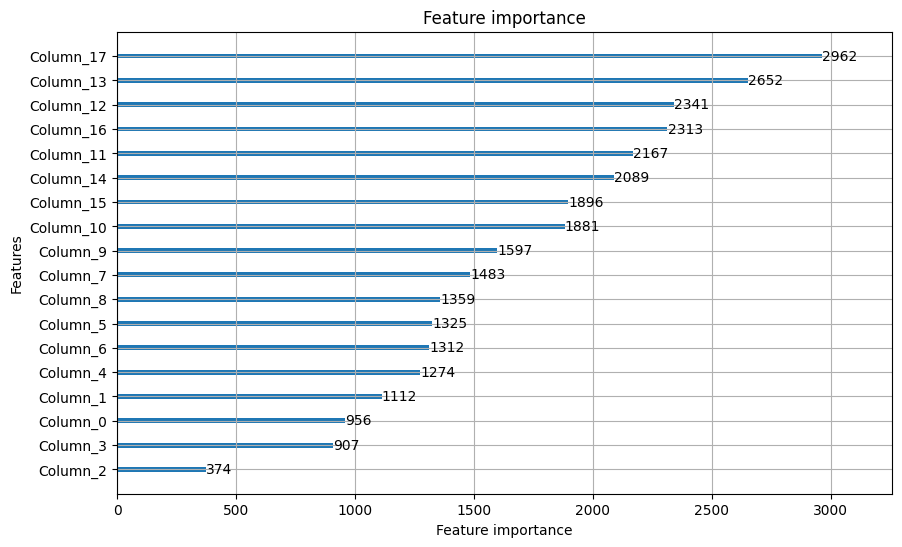

In [8]:
# Plot feature importance
lgb.plot_importance(bst, max_num_features=20, figsize=(10, 6), importance_type='split')
plt.show()

```python
date_encoded (Column_17):  2962
image_features (Column_13): 2652
10 (Column_12): 2341
fab_gtrend (Column_16): 2313
9 (Column_11): 2167
cat_gtrend (Column_14): 2089
col_gtrend (Column_15): 1896
8 (Column_10): 1881
7 (Column_9): 1597
5 (Column_7): 1483
6 (Column_8): 1359
3 (Column_5): 1325
4 (Column_6): 1312
2 (Column_4): 1274
fabric_encoded (Column_1): 1112
category_encoded (Column_0): 956
1 (Column_3): 907
color_encoded (Column_2): 374

```

# Final Evaluation

This code segment makes predictions using a LightGBM model (`bst`) on the training and validation data and calculates the Mean Squared Error (MSE) for both sets.


In [9]:
# Make predictions on the training and validation data.
y_train_pred = bst.predict(x_train)
y_test_pred = bst.predict(x_test)

# Calculate and print the  Mean Squared Error (MSE) for training and validation predictions.
print("Training MSE: ", (mse(y_train, y_train_pred)))
print("Validation MSE: ", (mse(y_test, y_test_pred)))

Training MSE:  0.8648028285167856
Validation MSE:  1.3360511754615518


In [10]:
model_mae = mae(y_test, y_test_pred)

mae_values = []
mae_values.append({"model":model_mae})
print("Model Validation mode_mae : ", model_mae)

#Weighted Absolute Percent Error
model_wape = ((mae(y_test,y_test_pred)*int(len(y_test_pred)) ) / sum(y_test)[0])*100
print("Model Validation wape : ", model_wape)

wape_values = []
wape_values.append({"model": model_wape})

Model Validation mode_mae :  0.7169118548672258
Model Validation wape :  110.50176234465692


## **Plot Sample Predictions**


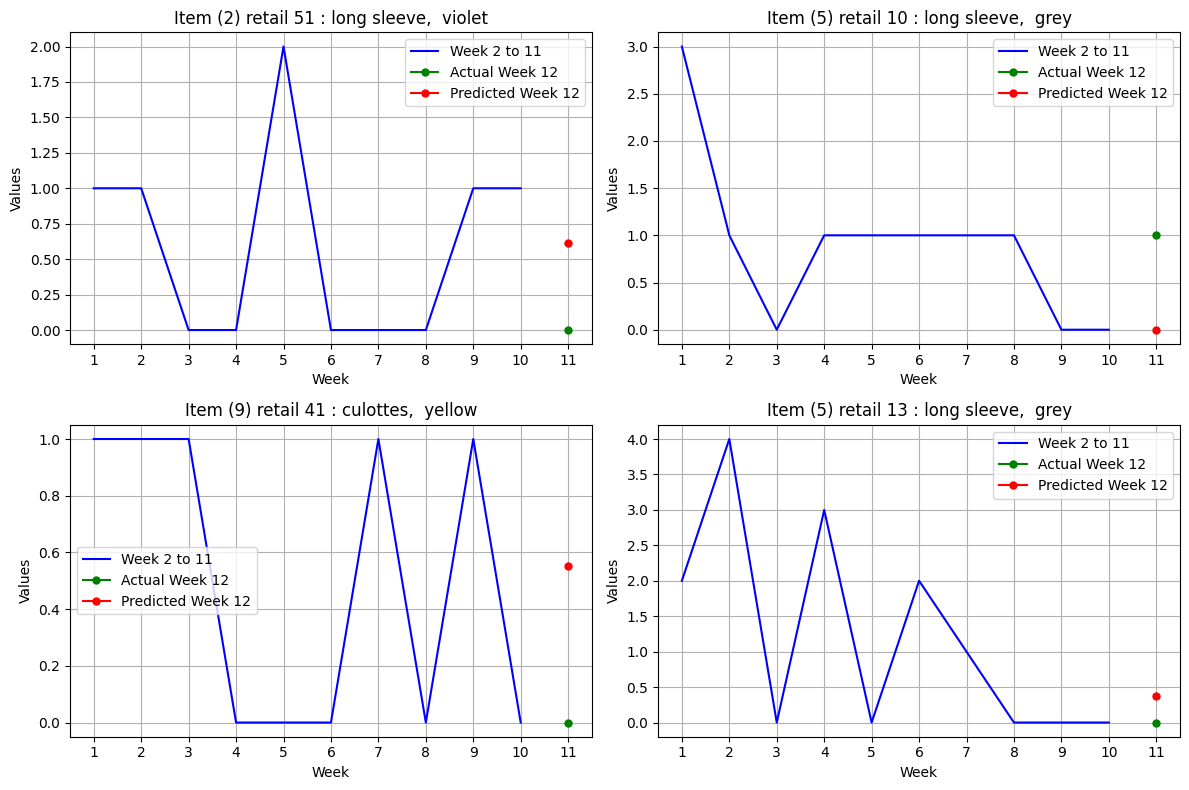

In [11]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axs.flat, start=1):
    # Plot original data from week 1 to 11 in blue
    ax.plot(range(1, 11), x_test_original[i, 3:13], color='blue', label='Week 2 to 11')

    # Plot actual data for week 12 in green
    ax.plot(11, y_test[i], marker='o', markersize=5, color='green', label='Actual Week 12')

    # Plot predicted data for week 12 in red
    ax.plot(11, y_test_pred[i], marker='o', markersize=5, color='red', label='Predicted Week 12')

    ax.set_xticks(range(1, 12))  # Set the x-axis ticks from 1 to 12
    ax.set_xlabel('Week')
    ax.set_ylabel('Values')
    ax.set_title(f'Item ({sales.external_code[i]}) retail {sales.retail[i]} : {sales.category[i]},  {sales.color[i]}')
    ax.legend()
    # Add a grid to the subplot
    ax.grid(True)

plt.tight_layout()
plt.show()

# Time Series Split A.K.A Walk Forward Cross Validation


In [12]:
params = {
    'objective': 'regression',
    'metric': 'mse',  # Adjust metric as needed
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

#TimeSeriesSplit Cross Validation

In [13]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
model = lgb.LGBMRegressor(**params)

mae_tscv = []
wape_tscv = []

# Loop over each split
for train_index, test_index in tscv.split(x_train):
    # Create training and test sets

    ## print('train:', train_index)
    ## print('test:',test_index)

    x_train_temp, x_test_temp = x_train[train_index], x_train[test_index]
    y_train_temp, y_test_temp = y_train[train_index], y_train[test_index]

    # Fit the model on the training data
    model.fit(x_train_temp, y_train_temp)

    # Make prediction
    y_pred = model.predict(x_test_temp)

    # Calculate Weighted Mean Absolute Percent Error for this fold
    wf_wape = ((mae(y_test_temp, y_pred)*len(y_pred)) / sum(y_test_temp)[0])*100
    wape_tscv.append(wf_wape)

    # Calculate Mean Absolute Error for this fold
    wf_mae = mae(y_test_temp, y_pred)
    mae_tscv.append(wf_mae)

    ## print("Fold MAE: ", wf_mae)
    ## print("Fold WAPE: ", wf_wape)


WAPE = sum(wape_tscv) / len(wape_tscv)
wape_values.append({"Walk forward CV": WAPE})

MAE = sum(mae_tscv) / len(mae_tscv)
mae_values.append({"Walk forward CV": MAE})

# Calculate and print mean WAPE and MAE across all folds
print('\n\n************ TimeseriesSplit/WalkForward Cross Validation ***************\n')
print("Mean WAPE : ", WAPE)
print("Mean MAE : ",  MAE)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 17810, number of used features: 18
[LightGBM] [Info] Start training from score 0.688995
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1389
[LightGBM] [Info] Number of data points in the train set: 35618, number of used features: 18
[LightGBM] [Info] Start training from score 0.723146
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 53426, number of used features: 18
[LightGBM] [Info] Start training from score 0.786864
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 71234, number of used features: 18
[LightGBM] [Info] Start training from score 0.751748
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 89042, number of used features: 18
[LightGBM] [Info] Start training from score 0.782462
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


************ TimeseriesSplit/WalkForward Cross Validation ***************

Mean WAPE :  101.83279012838973
Mean MAE :  0.7854610260548142


# Grouped Time Series Cross Validation

In [14]:
def group_time_series_cv(model, X, y, groups, n_splits=5):

    unique_groups = np.unique(groups)
    splits = np.array_split(unique_groups, n_splits+1)
    mse_gcv = []
    mae_gcv = []
    wape_gcv = []

    for i in range(len(splits)-1):
        train_groups = np.concatenate(splits[0:i+1])
        test_groups = splits[i+1]

        train_index = np.isin(groups, train_groups)
        test_index = np.isin(groups, test_groups)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Print unique values of X[:,12] for each split
        ##print("Unique values in train split:", np.unique(X_train[:,-1]))
        ##print("Unique values in test split:", np.unique(X_test[:,-1]))

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate performance
        gts_mse = mse(y_test, y_pred)
        mse_gcv.append(gts_mse)

        #Weighted Absolute Percent Error
        gts_wape = ((mae(y_test,y_pred)*int(len(y_pred)) ) / sum(y_test)[0])*100
        wape_gcv.append(gts_wape)

        gts_mae = mae(y_test, y_pred)
        mae_gcv.append(gts_mae)

        ##print(f"fold {i} gts_mae:", gts_mae)
        ##print(f"fold {i} gts_wape:",gts_wape)

    mse_gcv = np.array(mse_gcv)
    return mse_gcv, model, wape_gcv, mae_gcv

model_gcv = lgb.LGBMRegressor(**params)

groups = x_train[:,-1] #choose Last column(encoded release date)
#print('group_size:',groups.shape)

mse_gcv, model, wape_gcv, mae_gcv = group_time_series_cv(model_gcv, x_train, y_train, groups, n_splits=5)

WAPE = sum(wape_gcv) / len(wape_gcv)
wape_values.append({"Group CV": WAPE})

MAE = sum(mae_gcv)/len(mae_gcv)
mae_values.append({"Group CV": MAE})

print('\n\n************ Group Timeseries Cross Validation ***************\n')
print("Mean Squared Error:", mse_gcv.mean())
print("Mean WAPE", WAPE)
print("Mean MAE:", MAE)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 11585, number of used features: 18
[LightGBM] [Info] Start training from score 0.798619
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 28092, number of used features: 18
[LightGBM] [Info] Start training from score 0.748113
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1425
[LightGBM] [Info] Number of data points in the train set: 45924, number of used features: 18
[LightGBM] [Info] Start training from score 0.834422
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 63376, number of used features: 18
[LightGBM] [Info] Start training from score 0.786607
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 84601, number of used features: 18
[LightGBM] [Info] Start training from score 0.803099
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


************ Group Timeseries Cross Validation ***************

Mean Squared Error: 1.7140973526498962
Mean WAPE 108.86492272148625
Mean MAE: 0.8166881244921816


# Purged Group Time Series CV



In [15]:
# Creating custom cross validation for purged group cross validation
def purged_group_time_series_cv_iterative(X, y, groups, n_splits = 5, group_gap = 1 ):

    model = lgb.LGBMRegressor(**params)

    mse_scores = []
    mae_pgcv = []
    wape_pgcv = []

    unique_groups = np.unique(groups)
    splits = np.array_split(unique_groups, n_splits+1)


    for i in range(len(splits)-1):
        train_groups = splits[i].ravel()
        test_groups = splits[i+1].ravel()

        ##print('train:',train_groups)
        ##print('test:',test_groups)

        train_groups = train_groups[:-group_gap]
        test_groups = test_groups[group_gap:]

        train_index = np.isin(groups, train_groups)
        test_index = np.isin(groups, test_groups)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Print unique values of X[:,12] for each split
        ##print("Unique values in train split:", np.unique(X_train[:,-1]))
        ##print("Unique values in test split:", np.unique(X_test[:,-1]))

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate performance
        mse_pgcv = mse(y_test, y_pred)

        mse_scores.append(mse_pgcv)

        mae_fold = mae(y_test, y_pred)
        mae_pgcv.append(mae_fold)

        #Weighted Absolute Percent Error
        wape_fold = ((mae(y_test,y_pred)*int(len(y_pred)) ) / sum(y_test)[0])*100
        wape_pgcv.append(wape_fold)

        ##print(f"fold {i} pgcv_mae:", mae_pgcv)
        ##print(f"fold {i} pgcv_wape:",wape_fold)


    mse_scores = np.array(mse_scores)
    return mse_scores, model, mae_pgcv, wape_pgcv

groups = x_train[:,-1] #choose Last week

# Set the number of splits for cross-validation
n_splits = 5

# Set the group gap
group_gap = 1

# Perform Iterative Purged Group Time Series Cross-Validation
mse_scores, model, mae_pgcv, wape_pgcv = purged_group_time_series_cv_iterative(x_train, y_train, groups, n_splits=n_splits, group_gap=group_gap)

WAPE = sum(wape_pgcv) / len(wape_pgcv)
wape_values.append({"Purged Group CV": WAPE})

MAE = sum(mae_pgcv)/len(mae_pgcv)
mae_values.append({"Purged Group CV": MAE})

print('\n\n************ Purged Group Cross Validation ***************\n')
print("Mean Squared Error", mse_scores.mean())
print("Mean WAPE", WAPE)
print("Mean MAE:", MAE)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 10779, number of used features: 18
[LightGBM] [Info] Start training from score 0.800909
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 15746, number of used features: 18
[LightGBM] [Info] Start training from score 0.718405
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1226
[LightGBM] [Info] Number of data points in the train set: 16972, number of used features: 18
[LightGBM] [Info] Start training from score 0.992105
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1192
[LightGBM] [Info] Number of data points in the train set: 16745, number of used features: 18
[LightGBM] [Info] Start training from score 0.668856
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 20450, number of used features: 18
[LightGBM] [Info] Start training from score 0.864743
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


************ Purged Group Cross Validation ***************

Mean Squared Error 1.8443401752129478
Mean WAPE 112.06749110192477
Mean MAE: 0.8491002162335203


# Combinatorial Purged Group Cross Validation

In [16]:
def purge_and_embargo(arr,start = 0, end =  161):
  arr = np.sort(arr)
  indices = np.where(np.diff(arr) != 1)[0]
  new_arr = np.delete(arr, np.concatenate([indices, indices+1]))
  if new_arr[0] != start:
    new_arr = np.delete(new_arr, 0)
  if new_arr[-1] != end:
    new_arr = np.delete(new_arr, -1)
  return new_arr

In [21]:
def combinatorial_group_time_series_cv(model, X, y, groups, n_splits=6, test_set = 2):
    unique_groups = np.unique(groups)
    splits = np.array_split(unique_groups, n_splits)
    mse_scores = []
    mae_cpcv = []
    wape_cpcv = []

    test_splits = list(combinations(splits, 2))

    for i, test_groups in enumerate(test_splits):
        train_groups = [split for split in splits if all(split is not t for t in test_groups)]

        test_groups = np.concatenate(test_groups)
        train_groups = np.concatenate(train_groups)

        train_groups = purge_and_embargo(train_groups)
        test_groups = purge_and_embargo(test_groups)

        train_index = np.isin(groups, train_groups)
        test_index = np.isin(groups, test_groups)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Print unique values of X[:,12] for each split
        ##print("Unique values in train split:", np.unique(X_train[:,-1]))
        ##print("Unique values in test split:", np.unique(X_test[:,-1]))

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate performance
        mse_cpcv = mse(y_test, y_pred)
        mse_scores.append(mse_cpcv)

        #Weighted Absolute Percent Error
        wape_fold = ((mae(y_test,y_pred)*int(len(y_pred)) ) / sum(y_test)[0])*100
        wape_cpcv.append(wape_fold)

        mae_fold = mae(y_test, y_pred)
        mae_cpcv.append(mae_fold)

        ##print(f"split {i} cpcv_mae:", cpcv_mae)
        ##print(f"split {i} cpcv_wape:",cpcv_wape)

    mse_scores = np.array(mse_scores)
    return mse_scores, model, wape_cpcv, mae_cpcv

############################
model_i = lgb.LGBMRegressor(**params)

groups = x_train[:,-1] #choose Last column(encoded release date)
##print('group_size:',groups.shape)

mse_scores, model, wape_cpcv, mae_cpcv = combinatorial_group_time_series_cv(model_i, x_train, y_train, groups, n_splits=6, test_set=2)

WAPE = sum(wape_cpcv) / len(wape_cpcv)
wape_values.append({"Combinatorial Purged Group CV": WAPE})

MAE = sum(mae_cpcv)/len(mae_cpcv)
mae_values.append({"Combinatorial Purged Group CV": MAE})

print('\n\n************ Combinatorial Purged Group Cross Validation ***************\n')
print("Mean Squared Error:", mse_scores.mean())
print("Mean WAPE", WAPE)
print("Mean MAE", MAE)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 77891, number of used features: 18
[LightGBM] [Info] Start training from score 0.771835
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 75433, number of used features: 18
[LightGBM] [Info] Start training from score 0.714276
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 76096, number of used features: 18
[LightGBM] [Info] Start training from score 0.785705
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 72267, number of used features: 18
[LightGBM] [Info] Start training from score 0.737307
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 71522, number of used features: 18
[LightGBM] [Info] Start training from score 0.808604
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 71185, number of used features: 18
[LightGBM] [Info] Start training from score 0.725602
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train set: 70220, number of used features: 18
[LightGBM] [Info] Start training from score 0.807690
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1464
[LightGBM] [Info] Number of data points in the train set: 66391, number of used features: 18
[LightGBM] [Info] Start training from score 0.756277
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points in the train set: 65646, number of used features: 18
[LightGBM] [Info] Start training from score 0.834171
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 70667, number of used features: 18
[LightGBM] [Info] Start training from score 0.738704
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1464
[LightGBM] [Info] Number of data points in the train set: 65458, number of used features: 18
[LightGBM] [Info] Start training from score 0.688090
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1474
[LightGBM] [Info] Number of data points in the train set: 64713, number of used features: 18
[LightGBM] [Info] Start training from score 0.766322
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1469
[LightGBM] [Info] Number of data points in the train set: 66966, number of used features: 18
[LightGBM] [Info] Start training from score 0.766359
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 65376, number of used features: 18
[LightGBM] [Info] Start training from score 0.848935
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1471
[LightGBM] [Info] Number of data points in the train set: 62669, number of used features: 18
[LightGBM] [Info] Start training from score 0.790183
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


************ Combinatorial Purged Group Cross Validation ***************

Mean Squared Error: 1.7445460697481787
Mean WAPE 104.88833802901824
Mean MAE 0.8101904627262151


## **Compare WAPE Results**


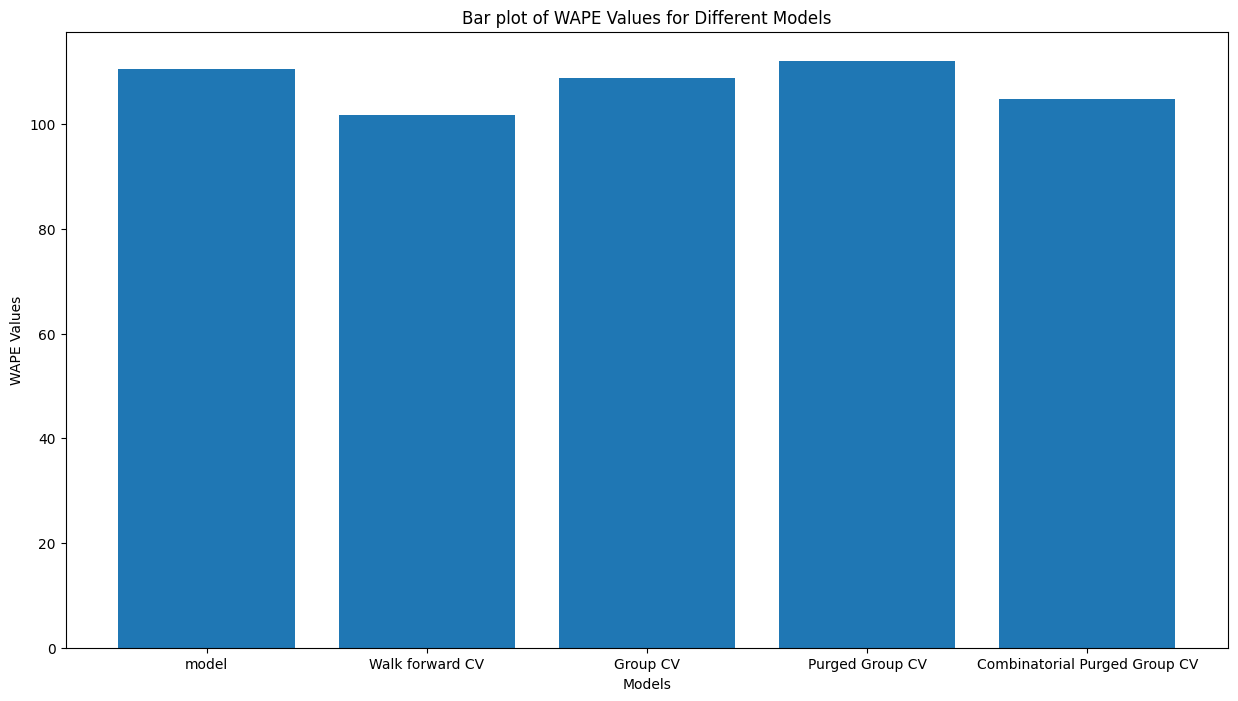

In [18]:
models = [list(item.keys())[0] for item in wape_values]
values = [list(item.values())[0] for item in wape_values]

# Create the bar plot
plt.figure(figsize=(15, 8))

plt.bar(models, values)
plt.xlabel('Models')
plt.ylabel('WAPE Values')
plt.title('Bar plot of WAPE Values for Different Models')
plt.show()

## **Compare MAE**

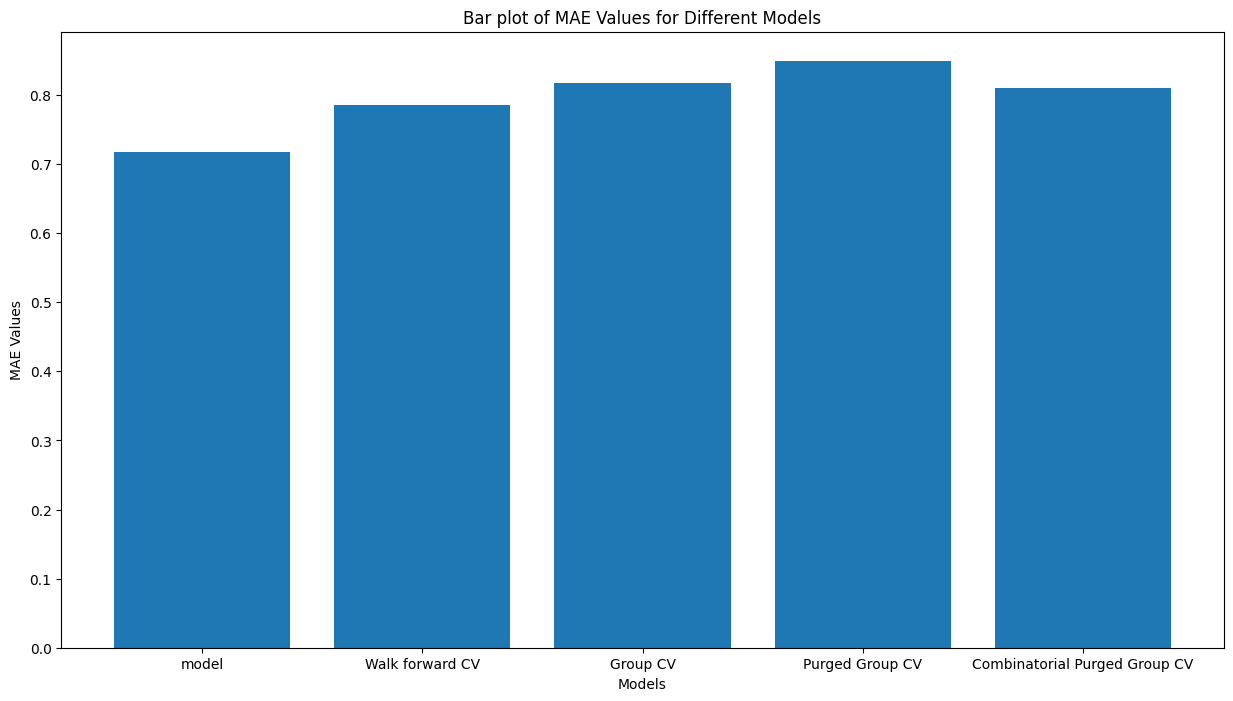

In [19]:
models = [list(item.keys())[0] for item in mae_values]
values = [list(item.values())[0] for item in mae_values]

# Create the bar plot
plt.figure(figsize=(15, 8))

plt.bar(models, values)
plt.xlabel('Models')
plt.ylabel('MAE Values')
plt.title('Bar plot of MAE Values for Different Models')
plt.show()

In [20]:
print("WAPE")
display(wape_values)

print("\n\n=============================\n\n")

print("MAE")
display(mae_values)

WAPE


[{'model': 110.50176234465692},
 {'Walk forward CV': 101.83279012838973},
 {'Group CV': 108.86492272148625},
 {'Purged Group CV': 112.06749110192477},
 {'Combinatorial Purged Group CV': 104.88833802901824}]





MAE


[{'model': 0.7169118548672258},
 {'Walk forward CV': 0.7854610260548142},
 {'Group CV': 0.8166881244921816},
 {'Purged Group CV': 0.8491002162335203},
 {'Combinatorial Purged Group CV': 0.8101904627262151}]